## Exploring relationships between climate variables and fungal biodiversity

We start by importing everything we will need

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

We read the dataset and see what's inside

In [2]:
df = pd.read_csv('./data/NEON_metadata.csv')

In [3]:
df.head()

plotID  longitude   latitude  collectYear  collectDOY  soil_pH  \
0  HARV_037 -72.179312  42.537308         2016          69     2.53   
1  BLAN_002 -77.980761  39.092296         2015         313     5.05   
2  BLAN_033 -78.069151  39.058229         2015         314     5.55   
3  BLAN_032 -78.073305  39.058572         2015         314     5.42   
4  SCBI_067 -78.135536  38.893949         2015         316     6.38   

   soil_moisture  temp_celsius    precip_mm  temp_seasonality  \
0          2.731      7.439394  1133.166667         93.017576   
1          0.236     11.634667   990.826667         85.453067   
2          0.245     11.634667   990.826667         85.453067   
3          0.348     11.634667   990.826667         85.453067   
4          0.426     11.229381  1015.396907         84.243763   

   precip_seasonality  fungal_diversity  
0            7.401515                13  
1           14.346667                 3  
2           14.346667                 4  
3           14.346667                 4  
4           15.000000                 3

In [4]:
df.shape

(6197, 12)

The number of unique location where samples where taken

In [5]:
len(df['plotID'].unique())

474

In [6]:
df.columns

Index(['plotID', 'longitude', 'latitude', 'collectYear', 'collectDOY',
       'soil_pH', 'soil_moisture', 'temp_celsius', 'precip_mm',
       'temp_seasonality', 'precip_seasonality', 'fungal_diversity'],
      dtype='object')

Let's do an exploration of the relationships between all variables, not just fungal biodiversity. This will give us an idea of what we might explore in more detail later.

In [7]:
cols_to_plot = ['soil_pH', 'soil_moisture', 'temp_celsius', 'precip_mm',
       'temp_seasonality', 'precip_seasonality', 'fungal_diversity']

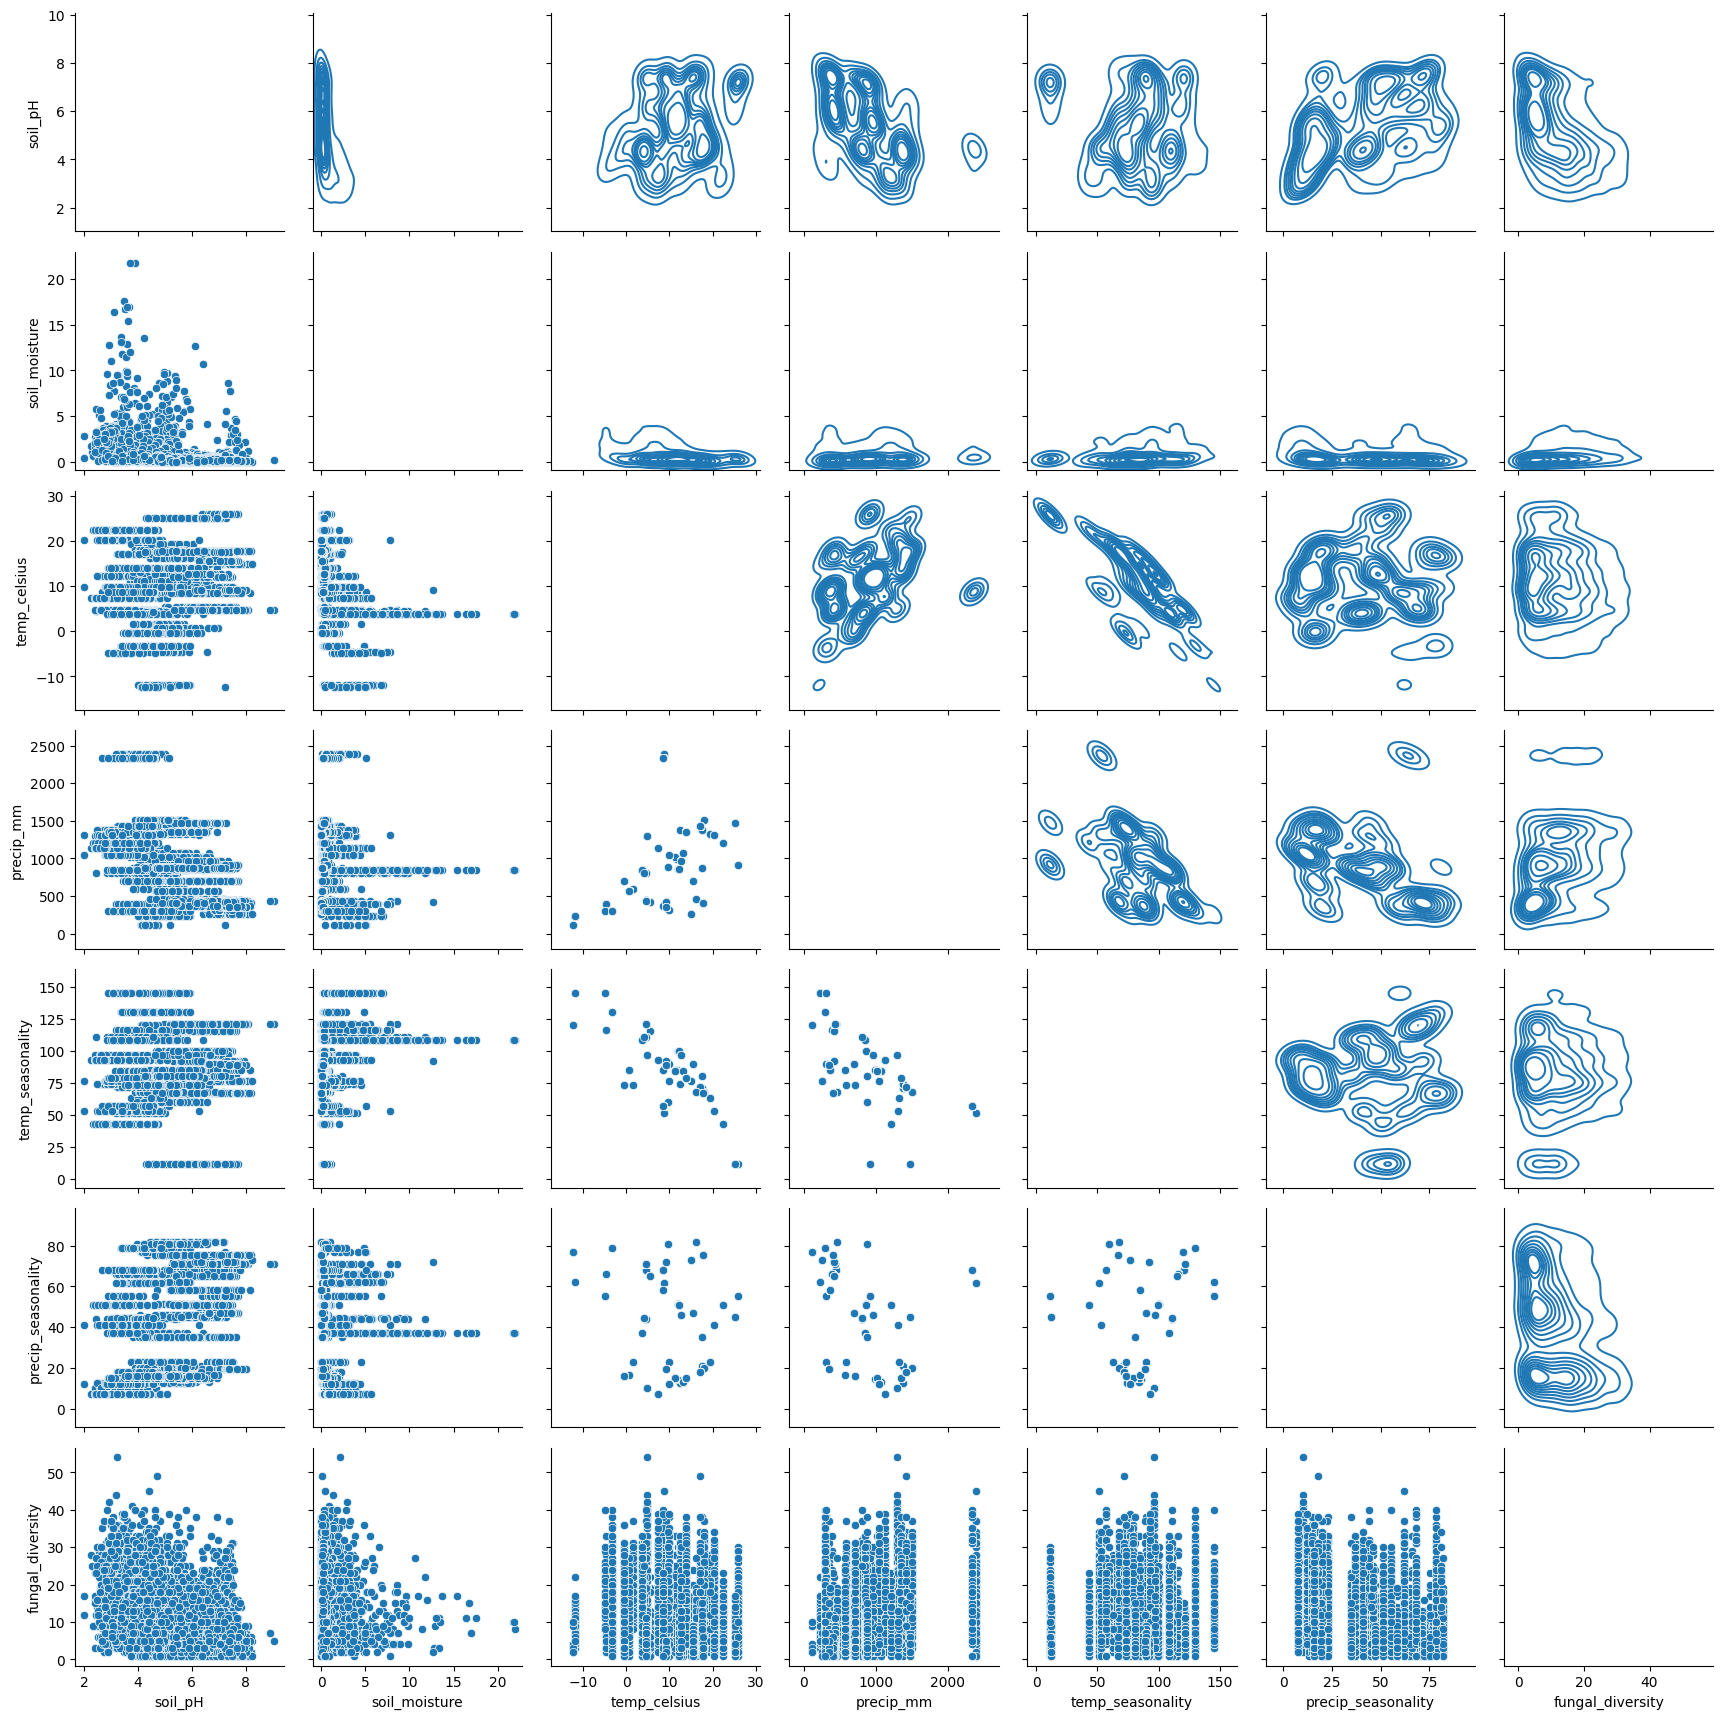

In [8]:
g = sns.PairGrid(df[cols_to_plot])
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot)
plt.show()

Hmmm, soil moisture seems to be promising.

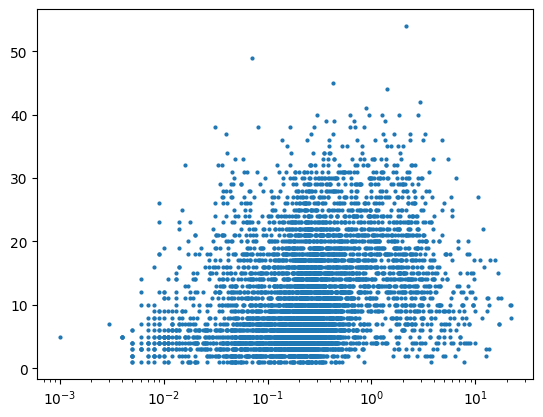

In [9]:
fig, ax = plt.subplots()
ax.scatter(df['soil_moisture'], df['fungal_diversity'], s=4)
ax.set_xscale('log')

Let's redo the previous plot but using our own code so that we can adjust the opacity and size of each dot, which will allow us to see more clearly the dot density.

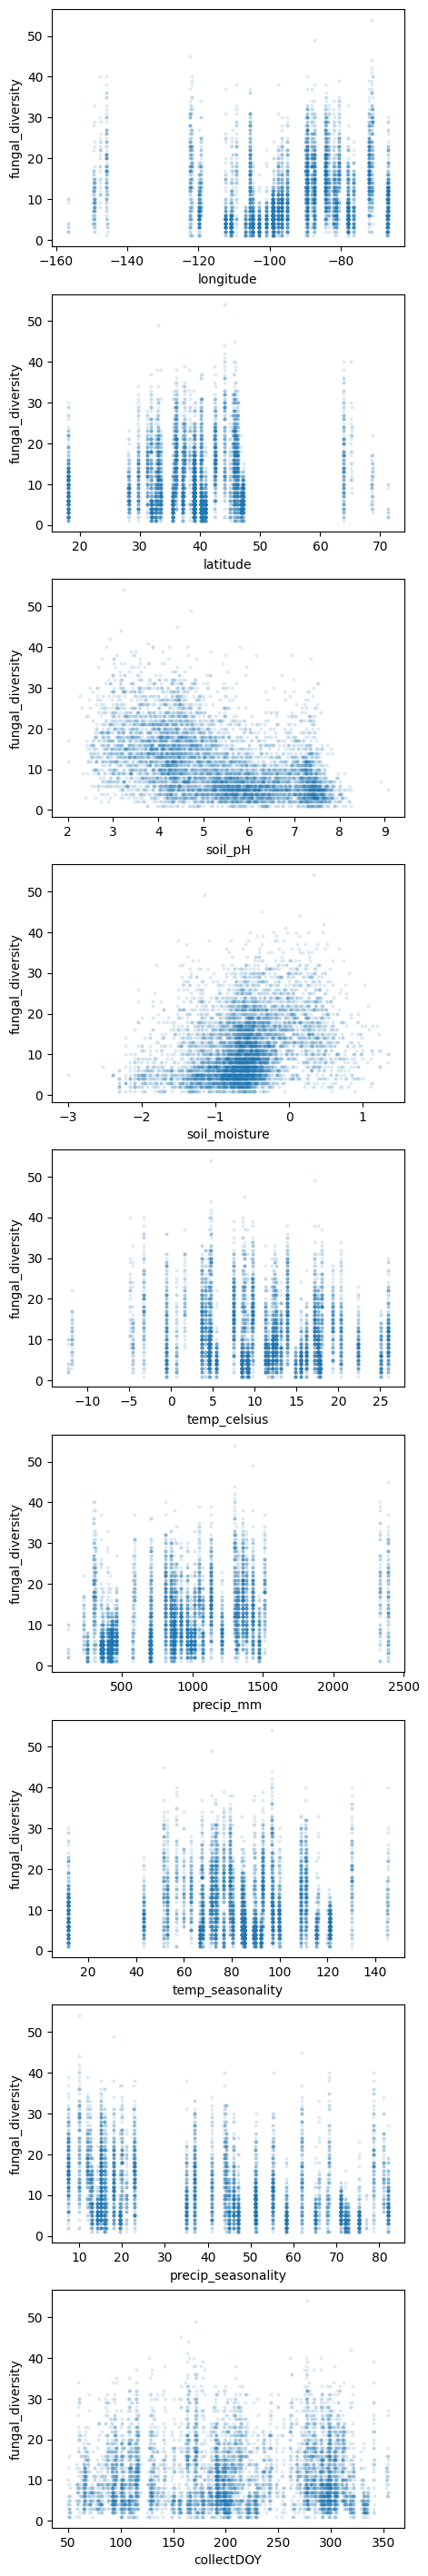

In [10]:
climate_variables = ['longitude', 'latitude', 'soil_pH', 'soil_moisture', 'temp_celsius', 'precip_mm',
       'temp_seasonality', 'precip_seasonality', 'collectDOY']
n_variables = len(climate_variables)

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    if (climate_variable == 'soil_moisture'):
        x = np.log10(df[climate_variable])
    else:
        x = df[climate_variable]
    ax[idx].scatter(x, df['fungal_diversity'], s=4, alpha=0.1)
    ax[idx].set_xlabel(climate_variable)
    ax[idx].set_ylabel('fungal_diversity')
    
        
plt.show()

Maybe we can try to see if there's anything going on with the year in which the samples were taken?

<AxesSubplot:xlabel='collectDOY', ylabel='fungal_diversity'>

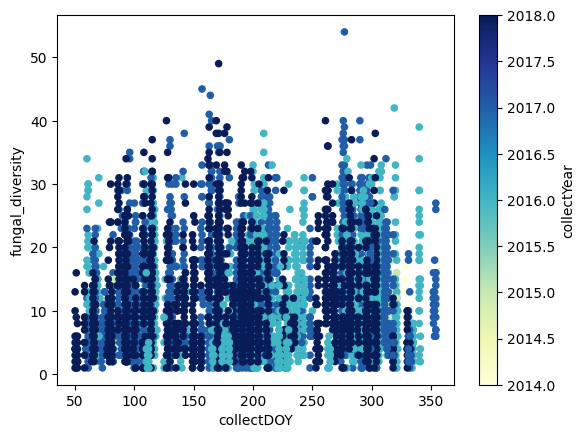

In [11]:
df.plot.scatter(x='collectDOY', y='fungal_diversity', c='collectYear', colormap='YlGnBu')

Or maybe we can try a different kind of plot. Let's see if box plots help with variables that have a limited number of variables (like `collectDOY` and `collectYear`)

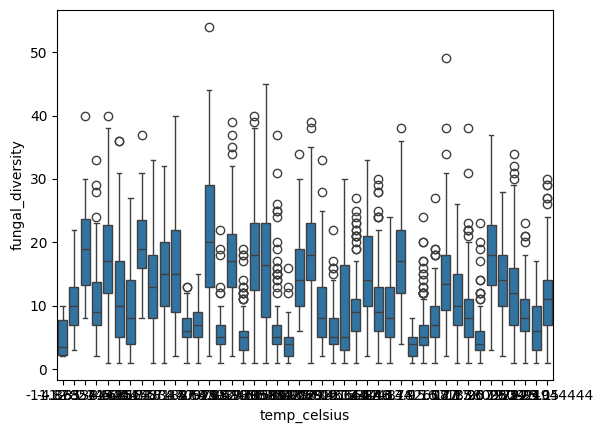

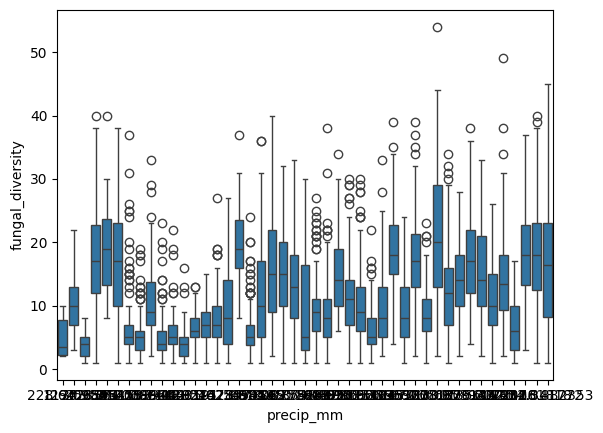

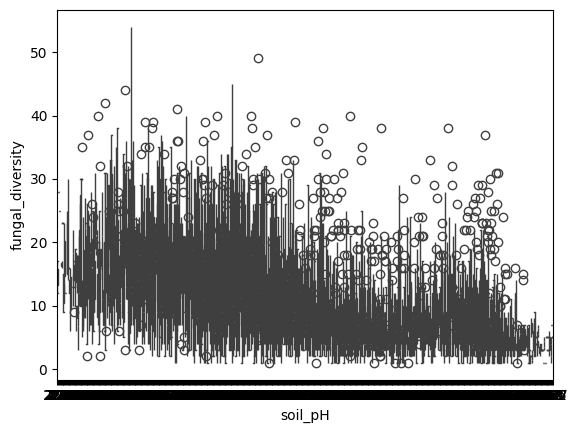

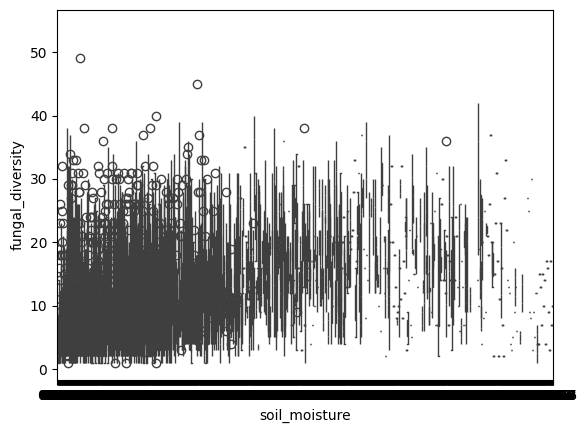

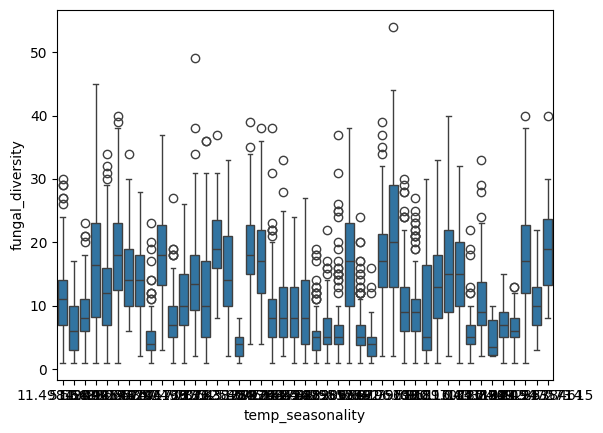

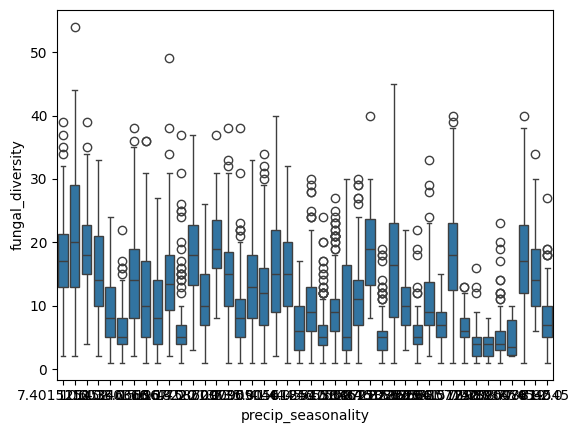

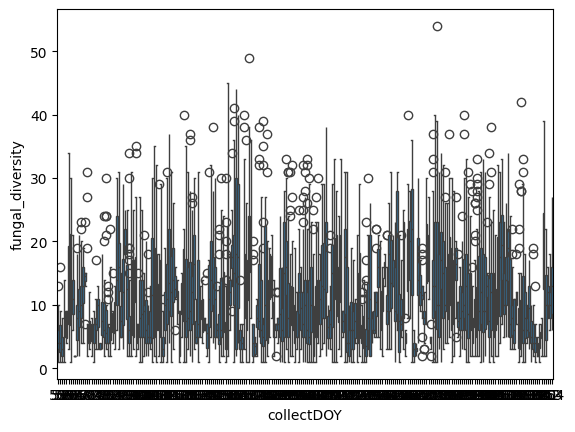

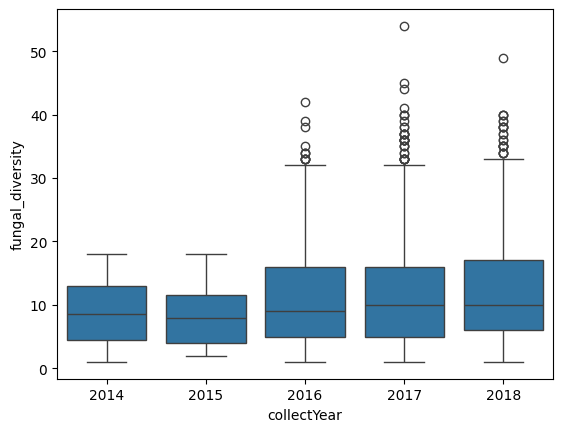

In [12]:
variables = ['temp_celsius', 'precip_mm', 'soil_pH', 'soil_moisture',
       'temp_seasonality', 'precip_seasonality', 'collectDOY', 'collectYear']

for variable in variables:
    sns.boxplot(data=df, x=variable, y='fungal_diversity')
    plt.show()

Hmm it's hard to see, but it seems like our best candidates are `soil_pH` and `soil_moisture`. Let's try to quantify such realtionship. For that, we will fit a few polynomial and see which one fits better the data.

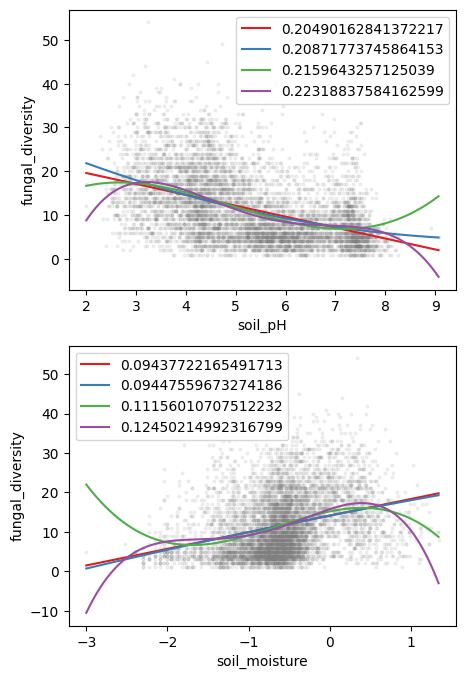

In [13]:
climate_variables = ['soil_pH', 'soil_moisture']
n_variables = len(climate_variables)
degrees = [1, 2, 3, 4]
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    valid = df['fungal_diversity'].notna() & df[climate_variable].notna()
    if (climate_variable == 'soil_moisture'):
        x = np.log10(df[climate_variable][valid])
    else:
        x = df[climate_variable][valid]
    y = df['fungal_diversity'][valid]
    xmin = x.min()
    xmax = x.max()
    xp = np.linspace(xmin, xmax, 1000)
    ax[idx].scatter(x, y, s=4, alpha=0.1, c='gray')
    ax[idx].set_xlabel(climate_variable)
    ax[idx].set_ylabel('fungal_diversity')
    for j, degree in enumerate(degrees):
        p = np.polyfit(x, y, degree)
        coeff = r2_score(y, np.polyval(p, x))
        ax[idx].plot(xp, np.polyval(p, xp), color=colors[j], label=coeff)
    ax[idx].legend()
        
# plt.legend()
plt.show()

The plot from above tells use that higher degree polynomial fit the data better (higher $R^2$ score), but the gain is not that significant. We might actually be overfitting our data with higher polynomial degree, so we will continue using a linear model.

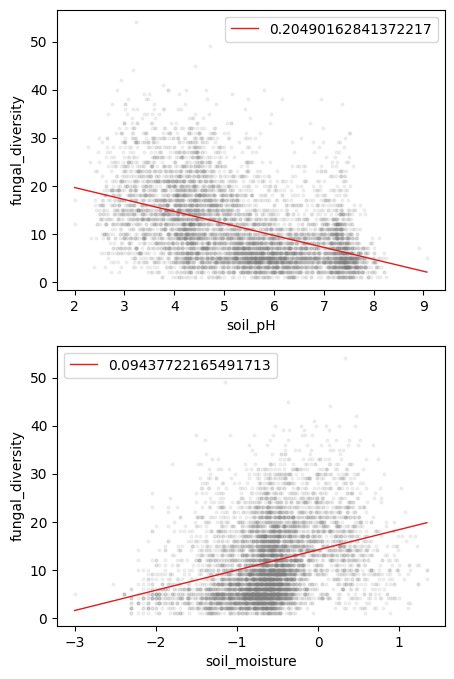

In [14]:
climate_variables = ['soil_pH', 'soil_moisture']
n_variables = len(climate_variables)
degrees = [1]
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
linreg = LinearRegression()

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    valid = df['fungal_diversity'].notna() & df[climate_variable].notna()
    if (climate_variable == 'soil_moisture'):
        x = np.log10(df[climate_variable][valid])
        logx = True
    else:
        x = df[climate_variable][valid]
        logx = False
    y = df['fungal_diversity'][valid]
    xmin = x.min()
    xmax = x.max()
    xp = np.linspace(xmin, xmax, 1000)
    ax[idx].scatter(x, y, s=4, alpha=0.1, c='gray')
    ax[idx].set_xlabel(climate_variable)
    ax[idx].set_ylabel('fungal_diversity')
    for j, degree in enumerate(degrees):
        p = np.polyfit(x, y, degree)
        coeff = r2_score(y, np.polyval(p, x))
        ax[idx].plot(xp, np.polyval(p, xp), color=colors[j], label=coeff, lw=1)
    ax[idx].legend()
        
plt.show()

## Adding NEON Field Sites

Now that we have an idea ok what relationships might exist for fungal biodiversity, we will add one more dataset: the NEON fiels sites shapefile.

In [15]:
import geopandas as gpd

In [16]:
neon = gpd.read_file('./data/NEONDomains_0/NEON_Domains.shp')

<AxesSubplot:>

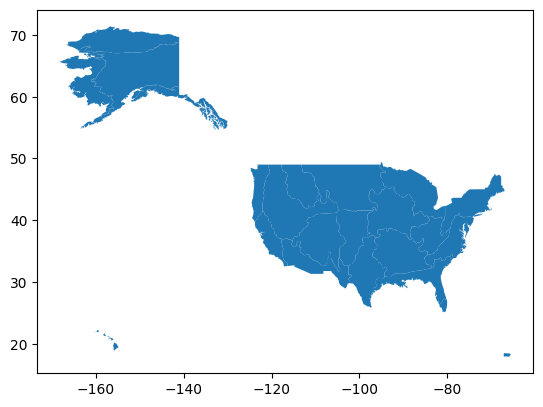

In [17]:
neon.plot()

We will transform our fungal biodiversity dataset into a geopands dataframe.

In [18]:
data = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs=neon.crs)

<AxesSubplot:>

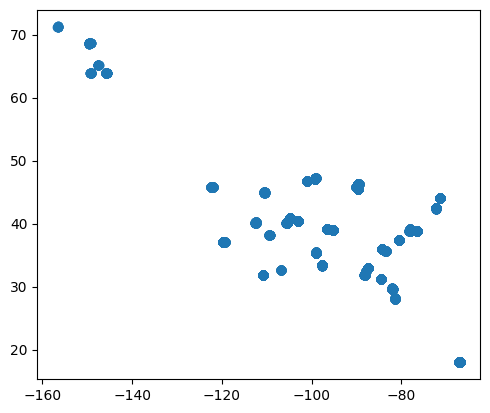

In [19]:
data.plot()

Let's verify that both datasets look good

<AxesSubplot:>

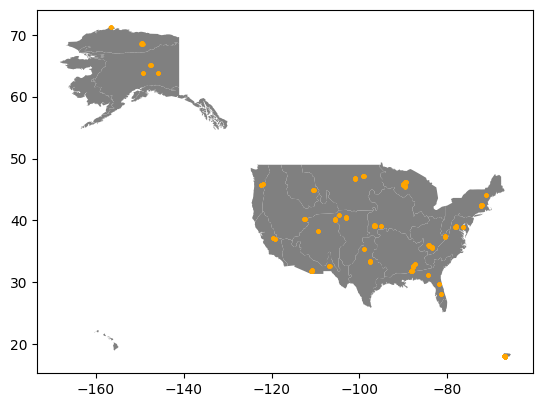

In [20]:
fig, ax = plt.subplots()

neon.plot(ax=ax, color='grey')
data.plot(ax=ax, color='orange', markersize=3)

And now we merge both datset in such a way that each sample has a new column specifying the NEON fiel site where it was taken.

In [21]:
merged_df = gpd.sjoin(data, neon, how='inner', predicate='within')

In [22]:
merged_df.tail(10)

plotID   longitude   latitude  collectYear  collectDOY  soil_pH  \
5729  YELL_051 -110.541571  44.954277         2018         192     5.04   
5730  YELL_046 -110.541582  44.952363         2018         193     6.11   
5731  YELL_009 -110.501884  44.970313         2018         193     4.71   
5732  YELL_009 -110.501884  44.970313         2018         193     5.36   
5954  YELL_051 -110.541571  44.954277         2018         254     5.47   
5955  YELL_051 -110.541571  44.954277         2018         254     5.31   
5956  YELL_051 -110.541571  44.954277         2018         254     5.49   
5957  YELL_052 -110.539286  44.954799         2018         255     5.00   
5958  YELL_052 -110.539286  44.954799         2018         255     4.91   
5959  YELL_052 -110.539286  44.954799         2018         255     5.28   

      soil_moisture  temp_celsius  precip_mm  temp_seasonality  \
5729          0.154           0.6      573.6            84.822   
5730          0.216           0.6      573.6            84.822   
5731          0.118           0.6      573.6            84.822   
5732          0.074           0.6      573.6            84.822   
5954          0.156           0.6      573.6            84.822   
5955          0.087           0.6      573.6            84.822   
5956          0.095           0.6      573.6            84.822   
5957          0.131           0.6      573.6            84.822   
5958          0.135           0.6      573.6            84.822   
5959          0.119           0.6      573.6            84.822   

      precip_seasonality  fungal_diversity                     geometry  \
5729                16.4                 6  POINT (-110.54157 44.95428)   
5730                16.4                11  POINT (-110.54158 44.95236)   
5731                16.4                14  POINT (-110.50188 44.97031)   
5732                16.4                27  POINT (-110.50188 44.97031)   
5954                16.4                 7  POINT (-110.54157 44.95428)   
5955                16.4                 6  POINT (-110.54157 44.95428)   
5956                16.4                 8  POINT (-110.54157 44.95428)   
5957                16.4                 8  POINT (-110.53929 44.95480)   
5958                16.4                24  POINT (-110.53929 44.95480)   
5959                16.4                15  POINT (-110.53929 44.95480)   

      index_right  OBJECTID  Shape_Leng  DomainID        DomainName  \
5729           13        63   29.365576        12  Northern Rockies   
5730           13        63   29.365576        12  Northern Rockies   
5731           13        63   29.365576        12  Northern Rockies   
5732           13        63   29.365576        12  Northern Rockies   
5954           13        63   29.365576        12  Northern Rockies   
5955           13        63   29.365576        12  Northern Rockies   
5956           13        63   29.365576        12  Northern Rockies   
5957           13        63   29.365576        12  Northern Rockies   
5958           13        63   29.365576        12  Northern Rockies   
5959           13        63   29.365576        12  Northern Rockies   

      Shape_Le_1  Shape_Area  
5729   29.365576   37.730214  
5730   29.365576   37.730214  
5731   29.365576   37.730214  
5732   29.365576   37.730214  
5954   29.365576   37.730214  
5955   29.365576   37.730214  
5956   29.365576   37.730214  
5957   29.365576   37.730214  
5958   29.365576   37.730214  
5959   29.365576   37.730214

Now we want to visualize how the samples for each NEON field site look with respecto to the rest of the samples. For that, we plot the samples taken in a specific field site in red, while the rest is plotted in gray. The later provides a bigger context in which to frame the samples for each site.

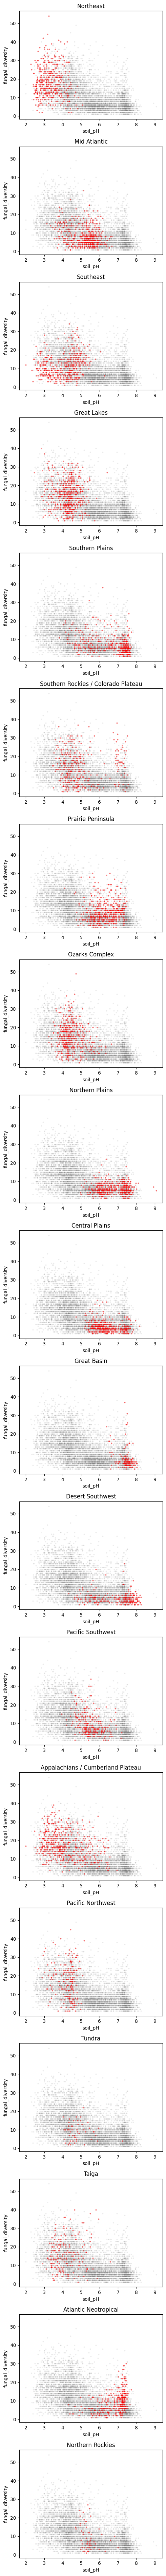

In [23]:
x = merged_df['soil_pH']
y = merged_df['fungal_diversity']
sites = merged_df['DomainName'].unique()
n_variables = len(sites)

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, site in enumerate(sites):
    ax[idx].scatter(x, y, s=4, alpha=0.1, color='gray')
    
    this_site = merged_df['DomainName'] == site
    
    ax[idx].scatter(x[this_site], y[this_site], s=4, alpha=0.4, color='red')
    ax[idx].set_xlabel('soil_pH')
    ax[idx].set_ylabel('fungal_diversity')
    ax[idx].set_title(site)
    

plt.tight_layout()
plt.show()

Let's improve the way this figure looks

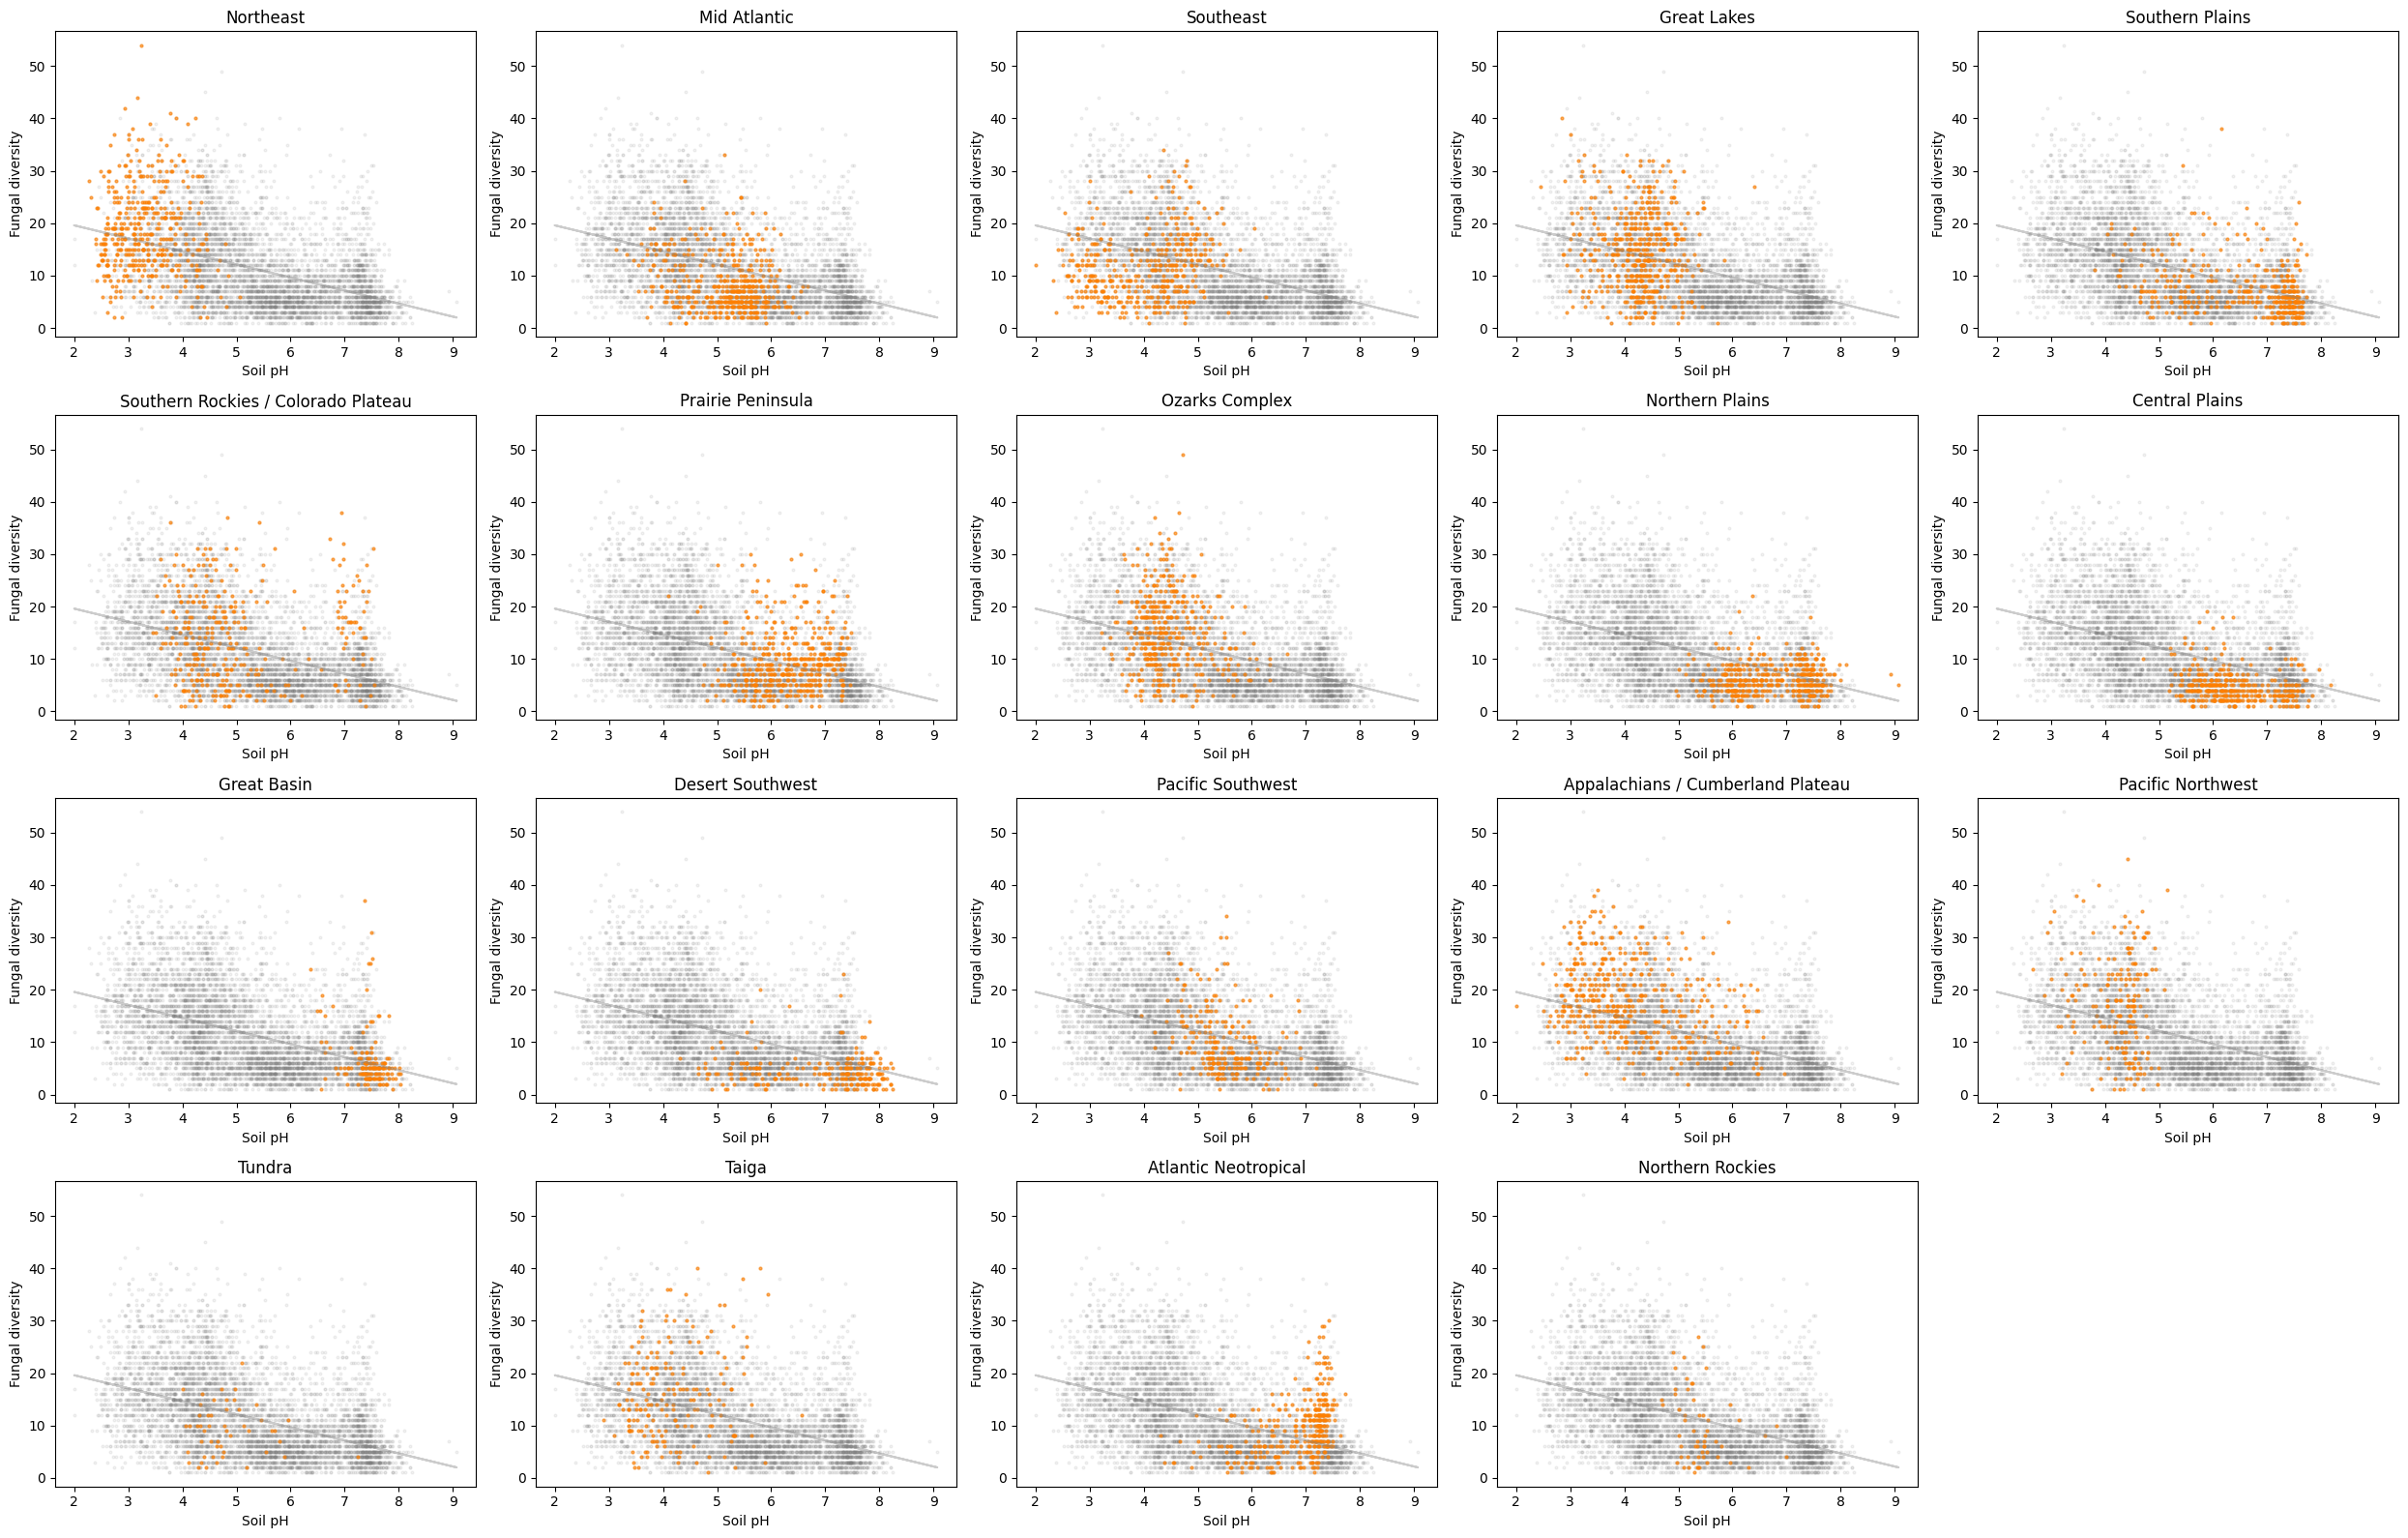

In [24]:
n_cols = 5

valid = merged_df['fungal_diversity'].notna() & merged_df['soil_pH'].notna()
    
x = merged_df['soil_pH'][valid]
y = merged_df['fungal_diversity'][valid]

sites = merged_df['DomainName'].unique()
n_variables = len(sites)
n_rows = int(n_variables / n_cols) + 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))

for idx, site in enumerate(sites):
    row = int(idx / n_cols)
    col = idx % n_cols
    
    ax[row][col].scatter(x, y, s=4, alpha=0.1, color='gray')
    linreg.fit(x.to_numpy().reshape(-1,1), y)
    
    ax[row][col].plot(x, linreg.predict(x.to_numpy().reshape(-1,1)), color='gray', lw=1.5, alpha=0.4)
    
    this_site = merged_df['DomainName'] == site
    
    ax[row][col].scatter(x[this_site], y[this_site], s=4, alpha=0.6, color='#ff7f00')
    ax[row][col].set_xlabel('Soil pH')
    ax[row][col].set_ylabel('Fungal diversity')
    ax[row][col].set_title(site)
    

# Hide unused subplot
ax[n_rows-1][n_cols-1].axis('off')
    
plt.tight_layout()
plt.show()

Most of the samples for a given field site are grouped relatively close to each other. This would suggest that -as an experiment- we can calculate average values for each field site.

In [25]:
sites_df = merged_df.groupby('DomainName').mean().reset_index()

In [26]:
sites_df['n_samples'] = merged_df.groupby('DomainName').agg(n_samples=('DomainName', 'count')).reset_index()['n_samples']

Now we explore is there are any relationship between variables for the NEON field sites.

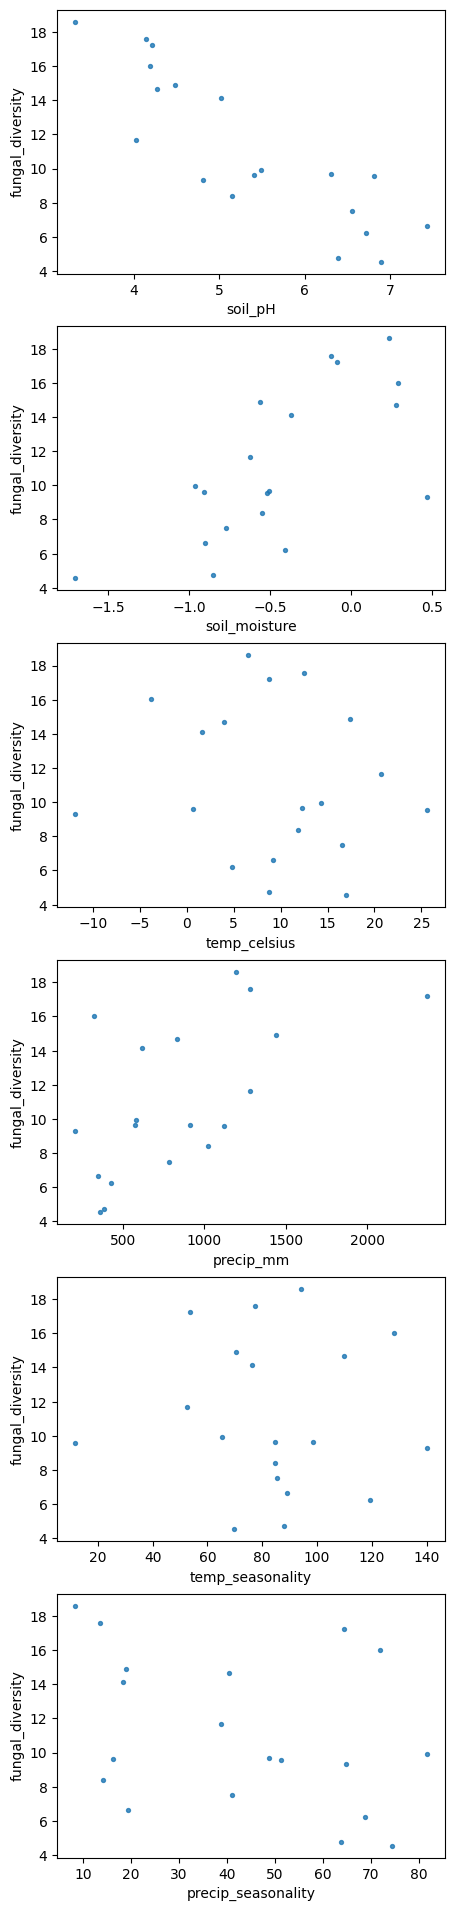

In [27]:
climate_variables = ['soil_pH', 'soil_moisture', 'temp_celsius', 'precip_mm',
       'temp_seasonality', 'precip_seasonality']
n_variables = len(climate_variables)

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    if (climate_variable == 'soil_moisture'):
        x = np.log10(sites_df[climate_variable])
    else:
        x = sites_df[climate_variable]
    ax[idx].scatter(x, sites_df['fungal_diversity'], s=8, alpha=0.8)
    ax[idx].set_xlabel(climate_variable)
    ax[idx].set_ylabel('fungal_diversity')
    
        
plt.show()

This new dataset seem to suggest stronger relationships than the previous one. Following a similar analysis, we can fit a first-order polynomia to our data and calculate the $R^2$ score. For that, we need to consider the number of samples taken at each site.

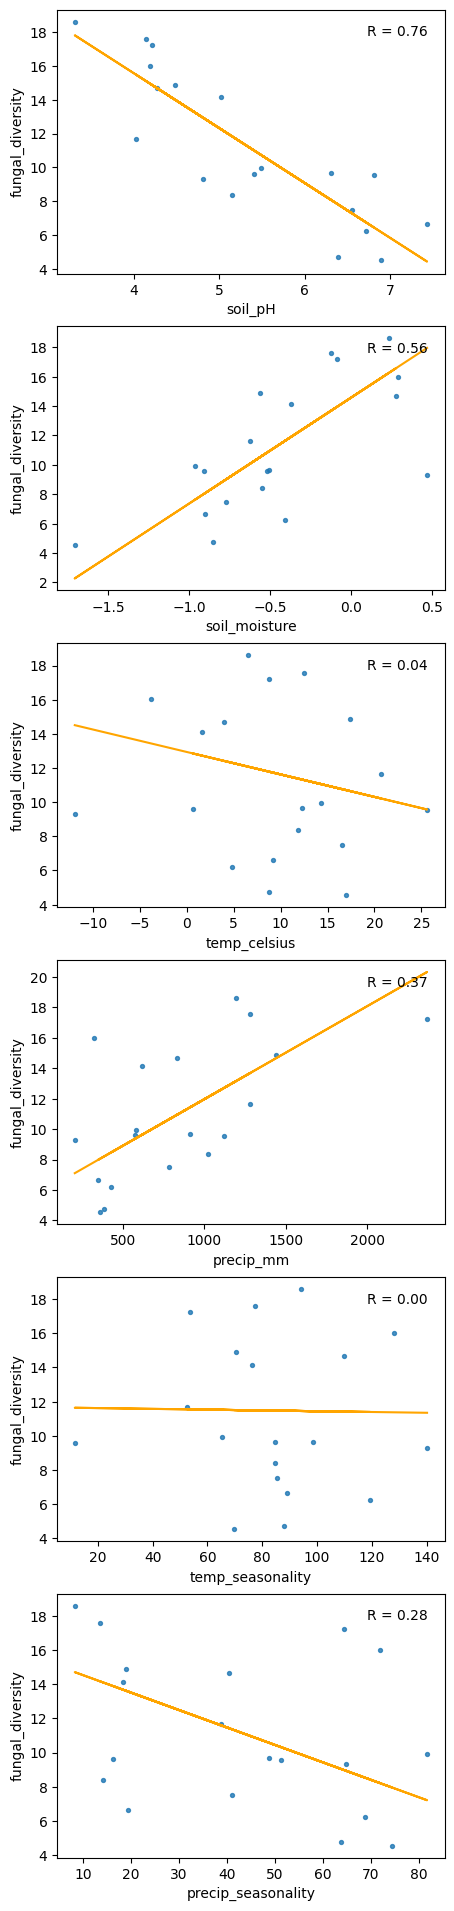

In [28]:
climate_variables = ['soil_pH', 'soil_moisture', 'temp_celsius', 'precip_mm',
       'temp_seasonality', 'precip_seasonality']
n_variables = len(climate_variables)
linreg = LinearRegression()

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    if (climate_variable == 'soil_moisture'):
        x = np.log10(sites_df[[climate_variable]])
    else:
        x = sites_df[climate_variable]
    y = sites_df[['fungal_diversity']]
    weights = sites_df['n_samples'].to_numpy()
    ax[idx].scatter(x, y, s=8, alpha=0.8)
    
    linreg.fit(x.to_numpy().reshape(-1,1), y, weights)
    r = linreg.score(x.to_numpy().reshape(-1,1), y, weights)
    
    ax[idx].plot(x, linreg.predict(x.to_numpy().reshape(-1,1)), color='orange', lw=1.5)
    ax[idx].text(0.8, 0.9, 'R = {:.2f}'.format(r), transform=ax[idx].transAxes)
    
    ax[idx].set_xlabel(climate_variable)
    ax[idx].set_ylabel('fungal_diversity')
    
        
plt.show()


Now we can improve our plots a little bit

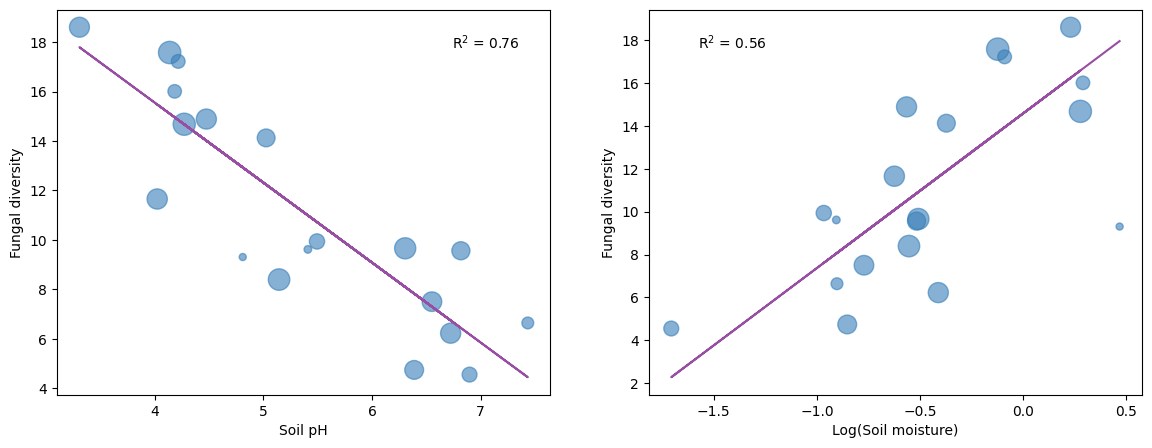

In [29]:
def get_label(variable):
    if variable == 'soil_pH':
        return "Soil pH"
    elif variable == 'soil_moisture':
        return "Log(Soil moisture)"
    else:
        return variable

climate_variables = ['soil_pH', 'soil_moisture']
n_variables = len(climate_variables)
linreg = LinearRegression()

fig, ax = plt.subplots(1, n_variables, figsize=(14, 5))

for idx, climate_variable in enumerate(climate_variables):
    if (climate_variable == 'soil_moisture'):
        x = np.log10(sites_df[[climate_variable]])
    else:
        x = sites_df[climate_variable]
    y = sites_df[['fungal_diversity']]
    weights = sites_df['n_samples'].to_numpy()
    ax[idx].scatter(x, y, s=weights/2, alpha=0.6, color='#377eb8')
    
    linreg.fit(x.to_numpy().reshape(-1,1), y, weights)
    r = linreg.score(x.to_numpy().reshape(-1,1), y, weights)
    
    ax[idx].plot(x, linreg.predict(x.to_numpy().reshape(-1,1)), color='#984ea3', lw=1.5)
    if (climate_variable == 'soil_moisture'):
        ax[idx].text(0.1, 0.9, 'R$^2$ = {:.2f}'.format(r), transform=ax[idx].transAxes)
    else:
        ax[idx].text(0.8, 0.9, 'R$^2$ = {:.2f}'.format(r), transform=ax[idx].transAxes)
    
    ax[idx].set_xlabel(get_label(climate_variable))
    ax[idx].set_ylabel('Fungal diversity')
    
fig.suptitle('')      
plt.show()


## Vegetation Index

To get the vegetation index we will use the Earth Engine Python API

In [30]:
import ee

In [31]:
ee.Authenticate()

True

In [32]:
ee.Initialize(project='fbecerra')

In [33]:
import datetime
import time

The rationale is the following:

* For each row of the fungal biodiversity we get its coordinates (from latitude and longitude) and date.
* We then defined an area around the lat,long pair with a buffer of 5000
* We get the [MODIS Conbined 16-Day](https://developers.google.com/earth-engine/datasets/catalog/modis) vegentation index for both NDVI and EVI
* We constrain our search to such area and the date in which the sample was taken.
* We then calculate the mean value of the vegetation index.
* We wrote the result to a `csv` file in Google Drive

Although this is not the most efficient way of calculating the vegetation index for each sample, we did it this way not to spend time optimizing the code.

In [34]:
# # NDVI
# for idx, row in df.iterrows():
    
#     if idx < 5139:
#         continue
        
#     year = row['collectYear']
#     days = row['collectDOY']
#     date = datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1)
    
#     ee_date = ee.Date(date)
    
#     locations = (
#         ee.List([[row['longitude'], row['latitude']]])
#             .map(lambda coords : ee.Feature(ee.Geometry.Point(coords).buffer(5000)))
#     )
#     area = ee.FeatureCollection(locations)

#     image = (
#         ee.ImageCollection('MODIS/MCD43A4_006_NDVI')
#             .filterDate(ee_date, ee_date.advance(1, 'day'))
#             .median()
#             .clip(area)
#     )

#     ndvi = image.select('NDVI') #input and output are images

#     ndvi_features = ndvi.reduceRegions(
#         collection = area,
#         reducer = ee.Reducer.mean(),
#         scale = 30,
#     )

#     ee.batch.Export.table.toDrive(
#         collection = ndvi_features,
#         description = 'ndvi_' + str(idx),
#         fileFormat = 'CSV',
#         folder = 'ndvi'
#     ).start()
    
#     time.sleep(0.5)


In [35]:
# # EVI

# for idx, row in df.iterrows():
#     year = row['collectYear']
#     days = row['collectDOY']
#     date = datetime.datetime(year, 1, 1) + datetime.timedelta(days - 1)
    
#     ee_date = ee.Date(date)
    
#     locations = (
#         ee.List([[row['longitude'], row['latitude']]])
#             .map(lambda coords : ee.Feature(ee.Geometry.Point(coords).buffer(5000)))
#     )
#     area = ee.FeatureCollection(locations)

#     image = (
#         ee.ImageCollection('MODIS/MCD43A4_006_EVI')
#             .filterDate(ee_date, ee_date.advance(1, 'day'))
#             .median()
#             .clip(area)
#     )

#     ndvi = image.select('EVI') #input and output are images

#     ndvi_features = ndvi.reduceRegions(
#         collection = area,
#         reducer = ee.Reducer.mean(),
#         scale = 30,
#     )

#     ee.batch.Export.table.toDrive(
#         collection = ndvi_features,
#         description = 'evi_' + str(idx),
#         fileFormat = 'CSV',
#         folder = 'evi'
#     ).start()
    
#     time.sleep(0.5)


Now we download the `csv` files from Google Drive and read them as pandas dataframe, to merge them with our main dataset.

In [36]:
ndvi_index = []
evi_index = []

for idx in range(merged_df.shape[0]):
    df_ndvi = pd.read_csv('./data/ndvi/ndvi_' + str(idx) + '.csv')
    ndvi_index.append(df_ndvi['mean'][0].item())
    
    df_evi = pd.read_csv('./data/evi/evi_' + str(idx) + '.csv')
    evi_index.append(df_evi['mean'][0].item())
    
merged_df['ndvi'] = ndvi_index
merged_df['evi'] = evi_index

We reuse the previous plots to see if there's any realtionship between the vegetation indices and fungal diversity

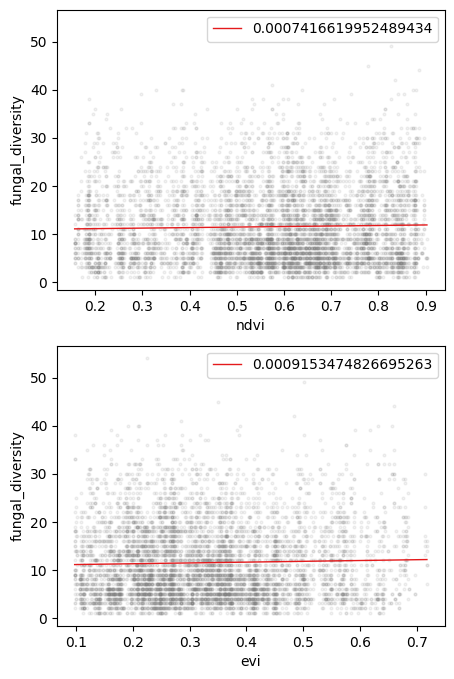

In [37]:
climate_variables = ['ndvi', 'evi']
n_variables = len(climate_variables)
degrees = [1]
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
linreg = LinearRegression()

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    valid = merged_df['fungal_diversity'].notna() & merged_df[climate_variable].notna()
    if (climate_variable == 'soil_moisture'):
        x = np.log10(merged_df[climate_variable][valid])
        logx = True
    else:
        x = merged_df[climate_variable][valid]
        logx = False
    y = merged_df['fungal_diversity'][valid]
    xmin = x.min()
    xmax = x.max()
    xp = np.linspace(xmin, xmax, 1000)
    ax[idx].scatter(x, y, s=4, alpha=0.1, c='gray')
    ax[idx].set_xlabel(climate_variable)
    ax[idx].set_ylabel('fungal_diversity')
    for j, degree in enumerate(degrees):
        p = np.polyfit(x, y, degree)
        coeff = r2_score(y, np.polyval(p, x))
        ax[idx].plot(xp, np.polyval(p, xp), color=colors[j], label=coeff, lw=1)
    ax[idx].legend()
        
plt.show()

Unfortunately, the plots suggest that there's no clear relationship between those variables. We can try to do a similar analysis to the previous one in which we calculate averages over NEON field sites and study if there's a relationship there

In [38]:
sites_df = merged_df.groupby('DomainName').mean().reset_index()
sites_df['n_samples'] = merged_df.groupby('DomainName').agg(n_samples=('DomainName', 'count')).reset_index()['n_samples']


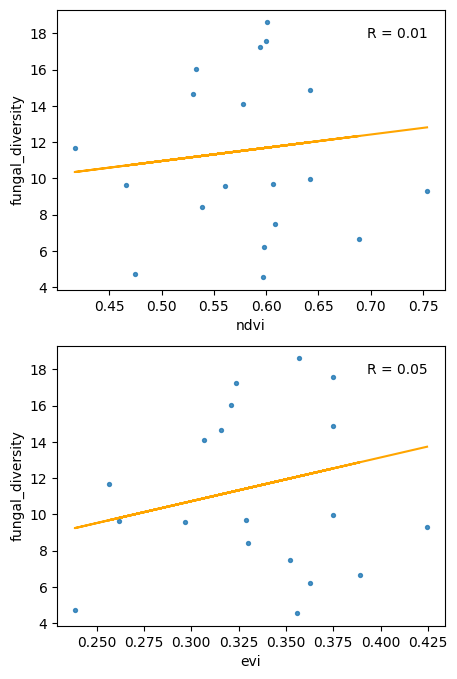

In [39]:
climate_variables = ['ndvi', 'evi']
n_variables = len(climate_variables)
linreg = LinearRegression()

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    if (climate_variable == 'soil_moisture'):
        x = np.log10(sites_df[[climate_variable]])
    else:
        x = sites_df[climate_variable]
    y = sites_df[['fungal_diversity']]
    weights = sites_df['n_samples'].to_numpy()
    ax[idx].scatter(x, y, s=8, alpha=0.8)
    
    linreg.fit(x.to_numpy().reshape(-1,1), y, weights)
    r = linreg.score(x.to_numpy().reshape(-1,1), y, weights)
    
    ax[idx].plot(x, linreg.predict(x.to_numpy().reshape(-1,1)), color='orange', lw=1.5)
    ax[idx].text(0.8, 0.9, 'R = {:.2f}'.format(r), transform=ax[idx].transAxes)
    
    ax[idx].set_xlabel(climate_variable)
    ax[idx].set_ylabel('fungal_diversity')
    
        
plt.show()


Hmmm it doesn't look like there's a strong relationship.

## Fungal abundance

We can try one more thing: we can get a loosely defined fungal abundance from the other dataset included. For that we are just gooing to get the total of number of times each species’ DNA sequences were observed for each observation.

In [40]:
df_species = pd.read_csv('./data/NEON_species_table.csv')

In [41]:
df_species.head()

plotID  collectYear  collectDOY  Russula_vinacea  Piloderma_sp  \
0  HARV_037         2016          69                0             0   
1  BLAN_002         2015         313                0             0   
2  BLAN_033         2015         314                0             0   
3  BLAN_032         2015         314                0             0   
4  SCBI_067         2015         316                0             0   

   Wilcoxina_rehmii  Russula_sp  Elaphomyces_cyanosporus  Tomentella_sp  \
0                 0           0                        0            239   
1                 0           0                        0             17   
2                 0           0                        0             10   
3                 0           0                        0           1223   
4                 0           0                        0            100   

   Russula_compacta  ...  Rhizopogon_nitidus  Lactarius_pubescens  \
0                 0  ...                   0                    0   
1                 0  ...                   0                    0   
2                 0  ...                   0                    0   
3                 0  ...                   0                    0   
4                 0  ...                   0                    0   

   Inocybe_apiosmota  Tomentella_pyrolae  Cantharellus_hygrophoroides  \
0                  0                   0                            0   
1                  0                   0                            0   
2                  0                   0                            0   
3                  0                   0                            0   
4                  0                   0                            0   

   Inocybe_fuligineoatra  Russula_pectinata  Russula_pallidospora  \
0                      0                  0                     0   
1                      0                  0                     0   
2                      0                  0                     0   
3                      0                  0                     0   
4                      0                  0                     0   

   Byssocorticium_caeruleum  Sarcodon_leucopus  
0                         0                  0  
1                         0                  0  
2                         0                  0  
3                         0                  0  
4                         0                  0  

[5 rows x 1227 columns]

In [42]:
cols = [x for x in df_species.columns if not x in ['plotID', 'collectYear', 'collectDOY']]
cols

['Russula_vinacea',
 'Piloderma_sp',
 'Wilcoxina_rehmii',
 'Russula_sp',
 'Elaphomyces_cyanosporus',
 'Tomentella_sp',
 'Russula_compacta',
 'Lactifluus_corrugis',
 'Clavulina_coralloides',
 'Russula_heterophylla',
 'Cortinarius_emodensis',
 'Russula_pectinatoides',
 'Piloderma_bicolor',
 'Cortinarius_sp',
 'Amanita_brunnescens',
 'Russula_variata',
 'Tricholoma_equestre',
 'Byssocorticium_sp',
 'Amanita_flavoconia',
 'Russula_pulchra',
 'Russula_nigricans',
 'Craterellus_tubaeformis',
 'Hebeloma_sp',
 'Russula_velenovskyi',
 'Tricholoma_davisiae',
 'Lactarius_imperceptus',
 'Tricholoma_saponaceum',
 'Cortinarius_mucosus',
 'Cortinarius_brunneocalcarius',
 'Cortinarius_ochrophyllus',
 'Inocybe_tubarioides',
 'Russula_melliolens',
 'Hygrophorus_russula',
 'Lactarius_rufus',
 'Lactifluus_allardii',
 'Sebacina_sp',
 'Russula_subsulphurea',
 'Piloderma_sphaerosporum',
 'Tomentella_ellisii',
 'Tuber_oregonense',
 'Russula_dissimulans',
 'Russula_murrillii',
 'Russula_sardonia',
 'Piloderma_

In [43]:
merged_df['fungal_abundance'] = df_species[cols].sum(axis=1)

And then we repeat the analysis previously done for `fungi_diversity`, but using `fungi_abundance` instead. First we study if there's any strong general relation for all samples.

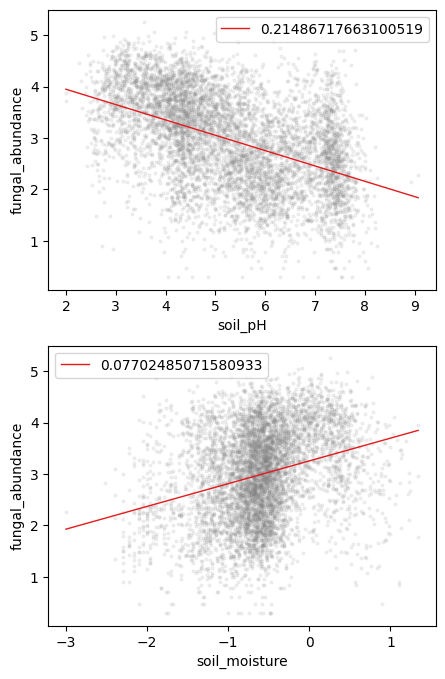

In [45]:
climate_variables = ['soil_pH', 'soil_moisture']
n_variables = len(climate_variables)
degrees = [1]
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
linreg = LinearRegression()

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    valid = merged_df['fungal_abundance'].notna() & merged_df[climate_variable].notna()
    if (climate_variable == 'soil_moisture'):
        x = np.log10(merged_df[climate_variable][valid])
        logx = True
    else:
        x = merged_df[climate_variable][valid]
        logx = False
    y = np.log10(merged_df['fungal_abundance'][valid])
    xmin = x.min()
    xmax = x.max()
    xp = np.linspace(xmin, xmax, 1000)
    ax[idx].scatter(x, y, s=4, alpha=0.1, c='gray')
    ax[idx].set_xlabel(climate_variable)
    ax[idx].set_ylabel('fungal_abundance')
    for j, degree in enumerate(degrees):
        p = np.polyfit(x, y, degree)
        coeff = r2_score(y, np.polyval(p, x))
        ax[idx].plot(xp, np.polyval(p, xp), color=colors[j], label=coeff, lw=1)
    ax[idx].legend()
        
plt.show()

And then we study how the relationship changes if we divide the dataset based on NEON field sites

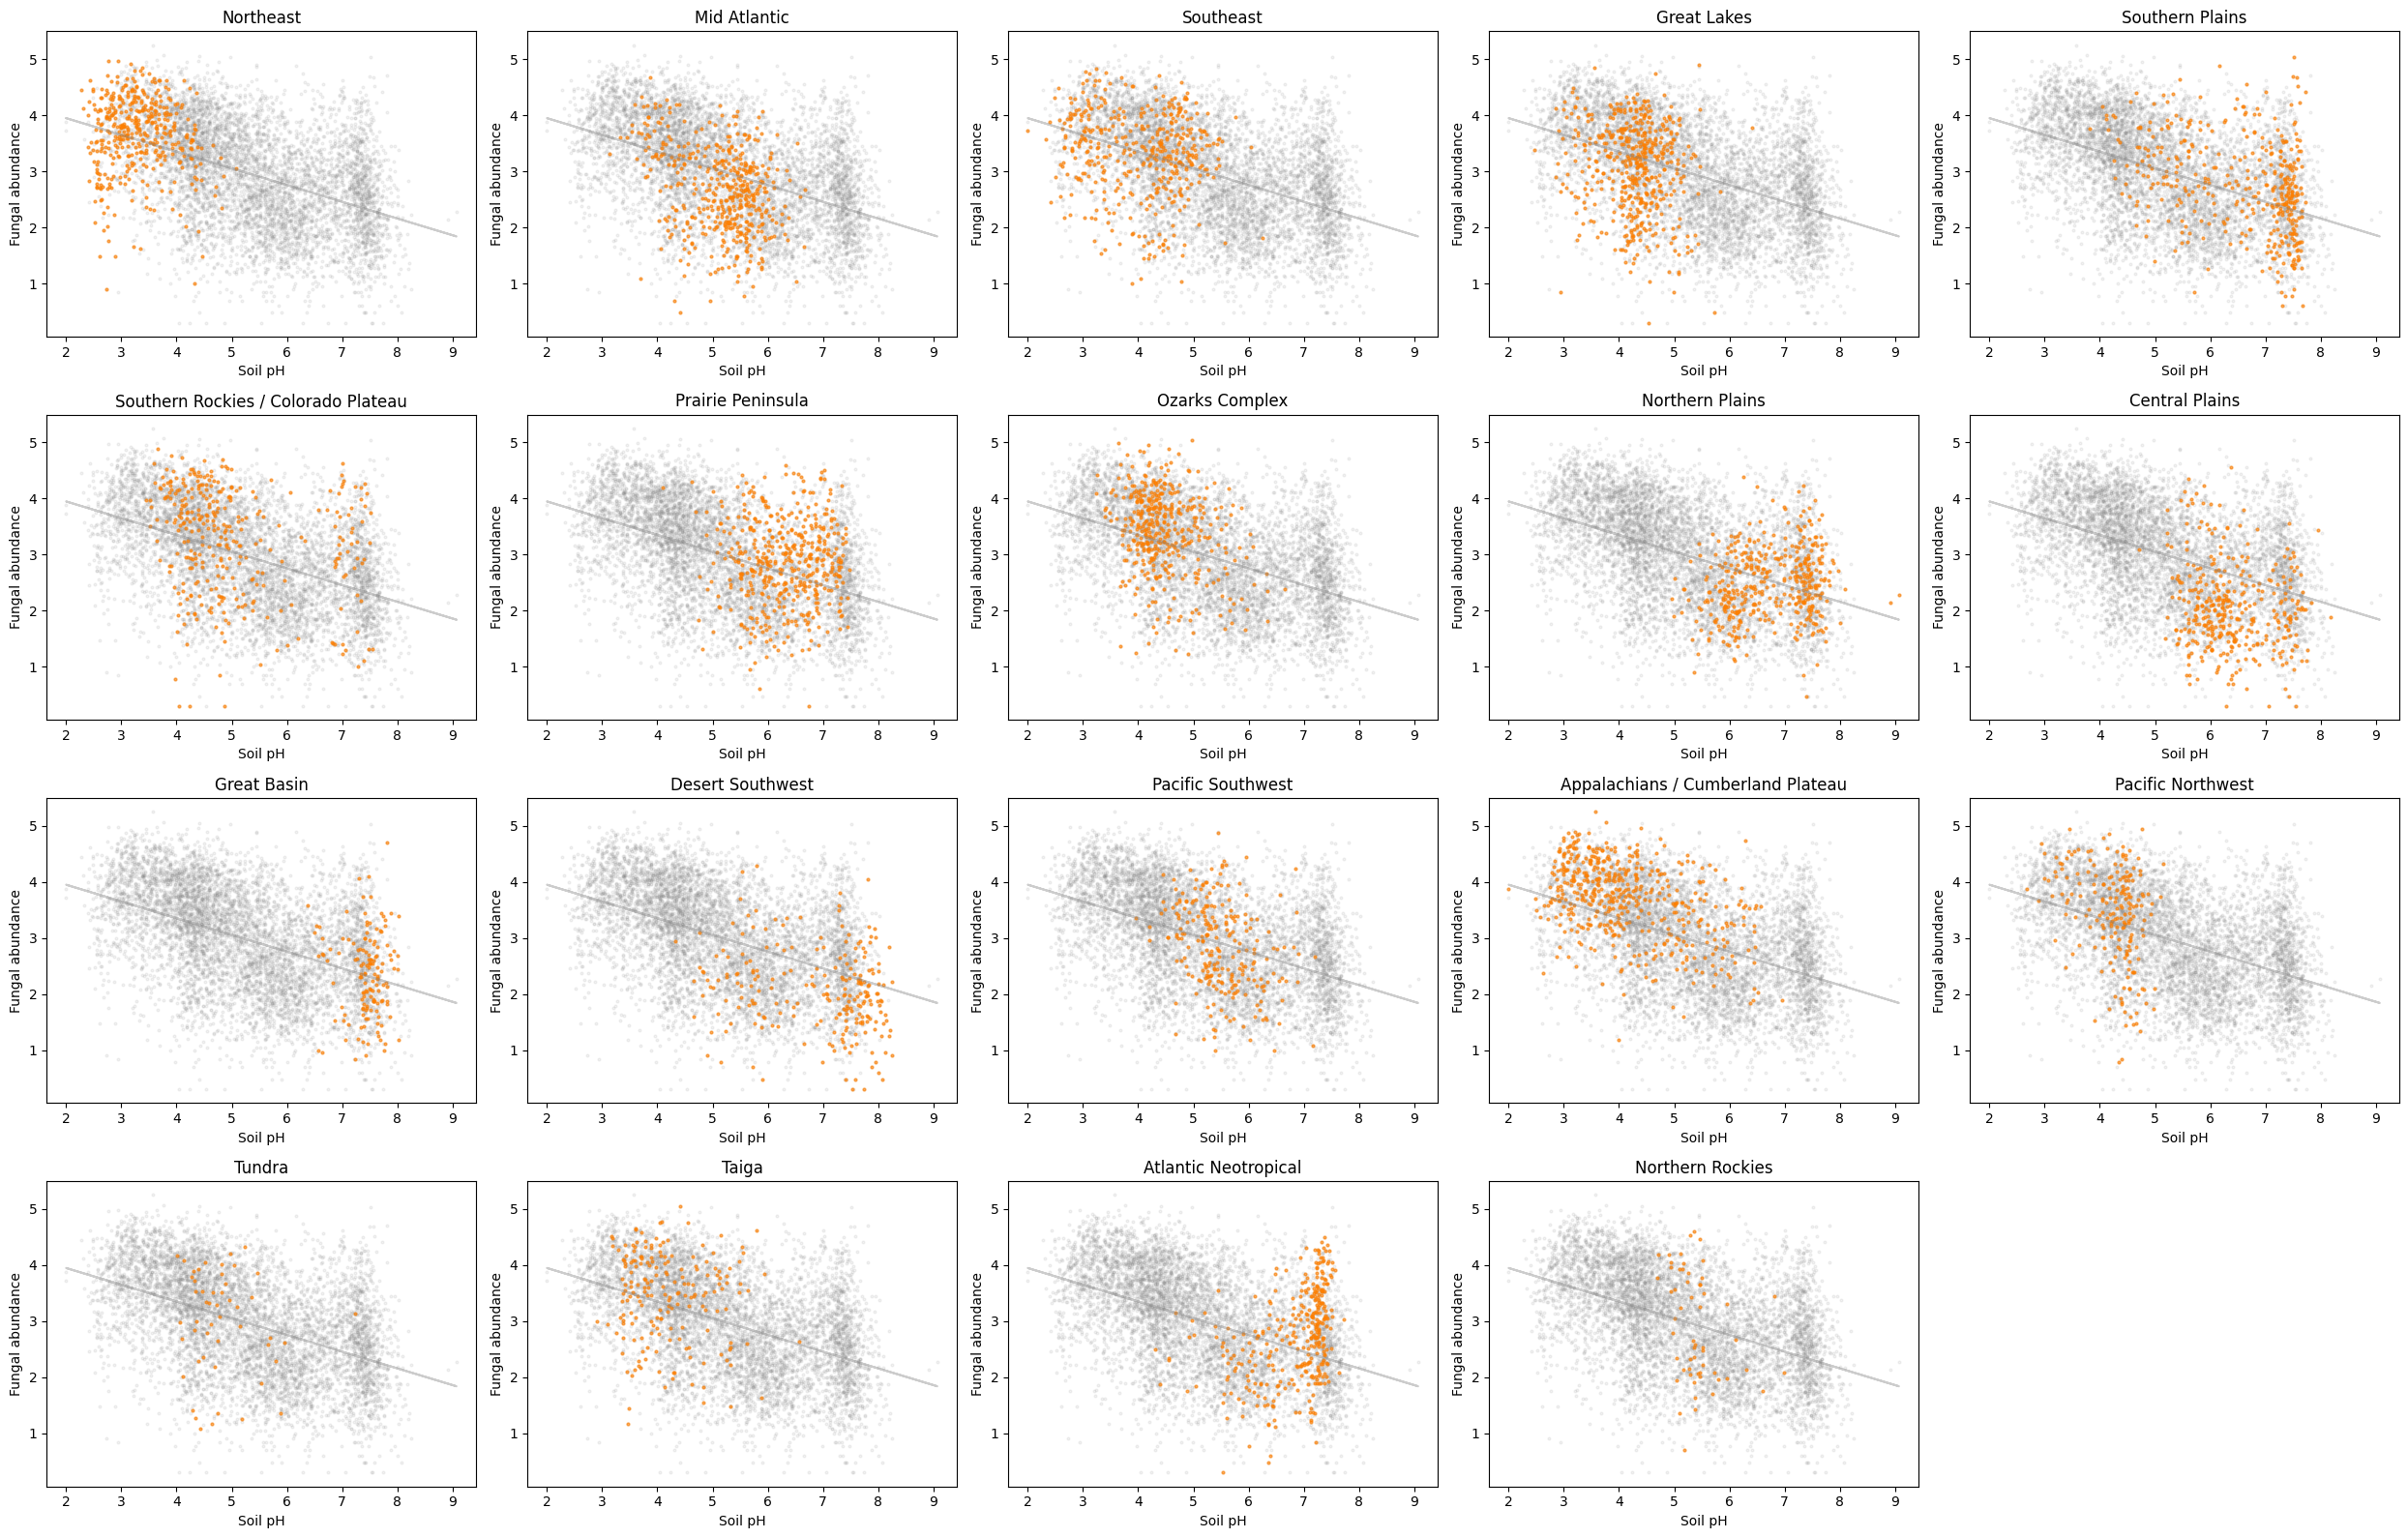

In [46]:
n_cols = 5

valid = merged_df['fungal_abundance'].notna() & merged_df['soil_pH'].notna()
    
x = merged_df['soil_pH'][valid]
y = np.log10(merged_df['fungal_abundance'][valid])

sites = merged_df['DomainName'].unique()
n_variables = len(sites)
n_rows = int(n_variables / n_cols) + 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))

for idx, site in enumerate(sites):
    row = int(idx / n_cols)
    col = idx % n_cols
    
    ax[row][col].scatter(x, y, s=4, alpha=0.1, color='gray')
    linreg.fit(x.to_numpy().reshape(-1,1), y)
    
    ax[row][col].plot(x, linreg.predict(x.to_numpy().reshape(-1,1)), color='gray', lw=1.5, alpha=0.4)
    
    this_site = merged_df['DomainName'] == site
    
    ax[row][col].scatter(x[this_site], y[this_site], s=4, alpha=0.6, color='#ff7f00')
    ax[row][col].set_xlabel('Soil pH')
    ax[row][col].set_ylabel('Fungal abundance')
    ax[row][col].set_title(site)
    

# Hide unused subplot
ax[n_rows-1][n_cols-1].axis('off')
    
plt.tight_layout()
plt.show()

In [47]:
sites_df = merged_df.groupby('DomainName').mean().reset_index()
sites_df['n_samples'] = merged_df.groupby('DomainName').agg(n_samples=('DomainName', 'count')).reset_index()['n_samples']


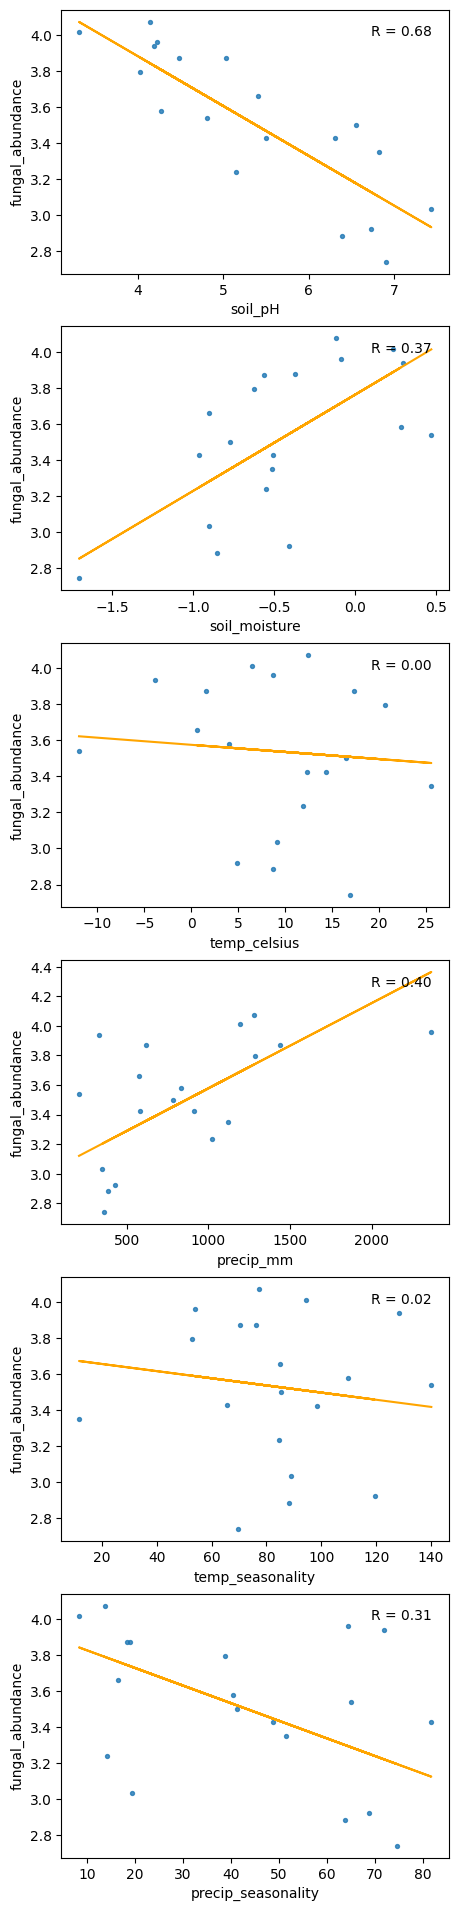

In [48]:
climate_variables = ['soil_pH', 'soil_moisture', 'temp_celsius', 'precip_mm',
       'temp_seasonality', 'precip_seasonality']
n_variables = len(climate_variables)
linreg = LinearRegression()

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    valid = sites_df[['fungal_abundance']] > 0
    if (climate_variable == 'soil_moisture'):
        x = np.log10(sites_df[[climate_variable]])
    else:
        x = sites_df[climate_variable]
    y = np.log10(sites_df[['fungal_abundance']])
    weights = sites_df['n_samples'].to_numpy()
    ax[idx].scatter(x, y, s=8, alpha=0.8)
    
    linreg.fit(x.to_numpy().reshape(-1,1), y, weights)
    r = linreg.score(x.to_numpy().reshape(-1,1), y, weights)
    
    ax[idx].plot(x, linreg.predict(x.to_numpy().reshape(-1,1)), color='orange', lw=1.5)
    ax[idx].text(0.8, 0.9, 'R = {:.2f}'.format(r), transform=ax[idx].transAxes)
    
    ax[idx].set_xlabel(climate_variable)
    ax[idx].set_ylabel('fungal_abundance')
    
        
plt.show()


It does seem to suggest a relation between soil pH, soil moisture, and even precipitation, although in the latter case there's an outlier that might be influencing the slope.

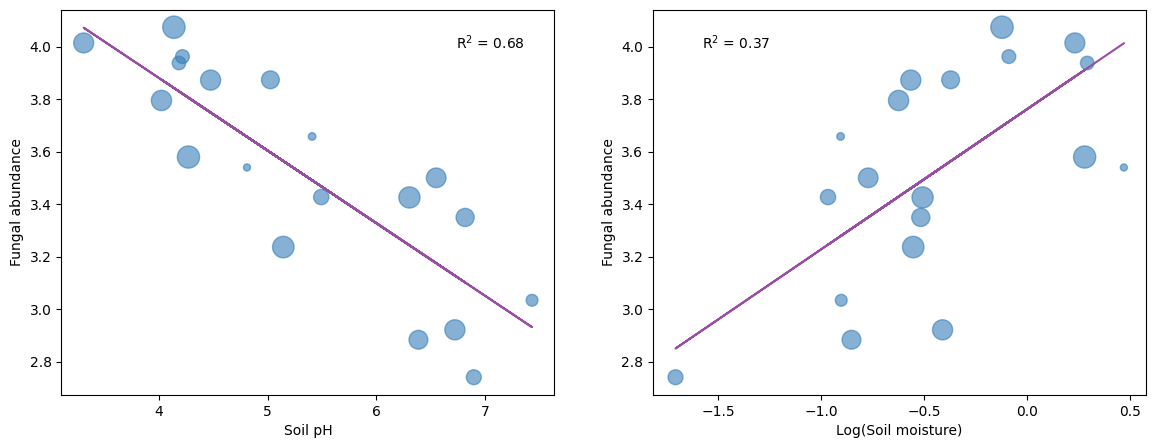

In [49]:
def get_label(variable):
    if variable == 'soil_pH':
        return "Soil pH"
    elif variable == 'soil_moisture':
        return "Log(Soil moisture)"
    else:
        return variable

climate_variables = ['soil_pH', 'soil_moisture']
n_variables = len(climate_variables)
linreg = LinearRegression()

fig, ax = plt.subplots(1, n_variables, figsize=(14, 5))

for idx, climate_variable in enumerate(climate_variables):
    if (climate_variable == 'soil_moisture'):
        x = np.log10(sites_df[[climate_variable]])
    else:
        x = sites_df[climate_variable]
    y = np.log10(sites_df[['fungal_abundance']])
    weights = sites_df['n_samples'].to_numpy()
    ax[idx].scatter(x, y, s=weights/2, alpha=0.6, color='#377eb8')
    
    linreg.fit(x.to_numpy().reshape(-1,1), y, weights)
    r = linreg.score(x.to_numpy().reshape(-1,1), y, weights)
    
    ax[idx].plot(x, linreg.predict(x.to_numpy().reshape(-1,1)), color='#984ea3', lw=1.5)
    if (climate_variable == 'soil_moisture'):
        ax[idx].text(0.1, 0.9, 'R$^2$ = {:.2f}'.format(r), transform=ax[idx].transAxes)
    else:
        ax[idx].text(0.8, 0.9, 'R$^2$ = {:.2f}'.format(r), transform=ax[idx].transAxes)
    
    ax[idx].set_xlabel(get_label(climate_variable))
    ax[idx].set_ylabel('Fungal abundance')
    
fig.suptitle('')      
plt.show()


That being done, let's try to see if the vegetation indices make any differencer in this case.

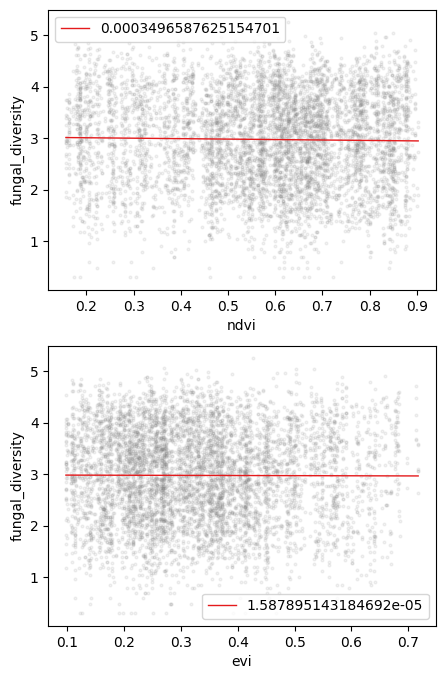

In [50]:
climate_variables = ['ndvi', 'evi']
n_variables = len(climate_variables)
degrees = [1]
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
linreg = LinearRegression()

fig, ax = plt.subplots(n_variables, 1, figsize=(5, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    valid = merged_df['fungal_abundance'].notna() & merged_df[climate_variable].notna()
    if (climate_variable == 'soil_moisture'):
        x = np.log10(merged_df[climate_variable][valid])
        logx = True
    else:
        x = merged_df[climate_variable][valid]
        logx = False
    y = np.log10(merged_df['fungal_abundance'][valid])
    xmin = x.min()
    xmax = x.max()
    xp = np.linspace(xmin, xmax, 1000)
    ax[idx].scatter(x, y, s=4, alpha=0.1, c='gray')
    ax[idx].set_xlabel(climate_variable)
    ax[idx].set_ylabel('fungal_diversity')
    for j, degree in enumerate(degrees):
        p = np.polyfit(x, y, degree)
        coeff = r2_score(y, np.polyval(p, x))
        ax[idx].plot(xp, np.polyval(p, xp), color=colors[j], label=coeff, lw=1)
    ax[idx].legend()
        
plt.show()

The plots seem to suggest that both fungal diversity and fungal abundance stay roughly constant across the range of vegetation indices.

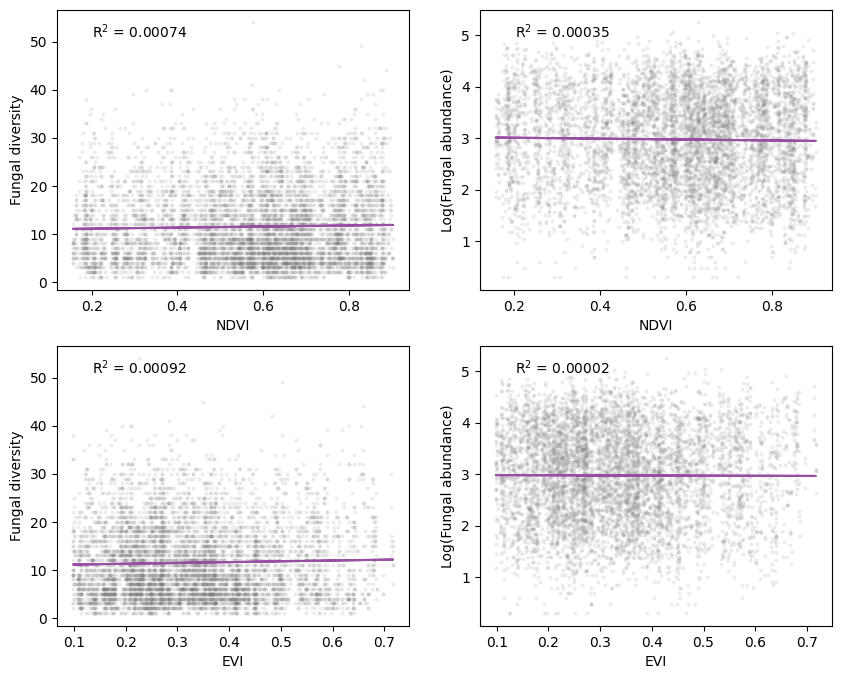

In [52]:
def get_climate_label(vi):
    return vi.upper()

def get_fungal_label(fv):
    if fv == 'fungal_abundance':
        return 'Log(Fungal abundance)'
    elif fv == 'fungal_diversity':
        return 'Fungal diversity'
    else:
        return fv

climate_variables = ['ndvi', 'evi']
fungal_variables = ['fungal_diversity', 'fungal_abundance']
n_variables = len(climate_variables)
degrees = [1]
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
linreg = LinearRegression()

fig, ax = plt.subplots(n_variables, 2, figsize=(10, n_variables * 4))

for idx, climate_variable in enumerate(climate_variables):
    for idx_fungal, fungal_variable in enumerate(fungal_variables):
        valid = merged_df[fungal_variable].notna() & merged_df[climate_variable].notna()
        if (climate_variable == 'soil_moisture'):
            x = np.log10(merged_df[climate_variable][valid])
            logx = True
        else:
            x = merged_df[climate_variable][valid]
            logx = False
            
        if fungal_variable == 'fungal_abundance':
            y = np.log10(merged_df[fungal_variable][valid])
        else:
            y = merged_df[fungal_variable][valid]
            
        xmin = x.min()
        xmax = x.max()
        ax[idx][idx_fungal].scatter(x, y, s=4, alpha=0.1, c='gray')
        ax[idx][idx_fungal].set_xlabel(get_climate_label(climate_variable))
        ax[idx][idx_fungal].set_ylabel(get_fungal_label(fungal_variable))
        
        linreg.fit(x.to_numpy().reshape(-1,1), y)
        r = linreg.score(x.to_numpy().reshape(-1,1), y)

        ax[idx][idx_fungal].plot(x, linreg.predict(x.to_numpy().reshape(-1,1)), color='#984ea3', lw=1.5)
        ax[idx][idx_fungal].text(0.1, 0.9, 'R$^2$ = {:.5f}'.format(r), transform=ax[idx][idx_fungal].transAxes)

        
plt.show()